In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import keras
import cv2
import tensorflow as tf
import pathlib
from google.colab import drive
from collections import Counter 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout
from keras import layers
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import TensorBoard
from keras import metrics

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_dir="/content/drive/MyDrive/brain"
yes_image=os.listdir(data_dir+'/yes')
no_image=os.listdir(data_dir+'/no')
pred_image=os.listdir(data_dir+'/pred')
mask_image=os.listdir(data_dir+'/Br35H-Mask-RCNN')

In [ ]:
dataset=[]
lab=[]

In [ ]:
hight=64
weight=64
for i in no_image:
  image=cv2.imread(data_dir+'/no/'+i)
  image=cv2.resize(image,(hight,weight))
  dataset.append(image)
  lab.append(0)

In [ ]:
for i in yes_image:
  image=cv2.imread(data_dir+'/yes/'+i)
  image=cv2.resize(image,(hight,weight))
  dataset.append(image)
  lab.append(1)

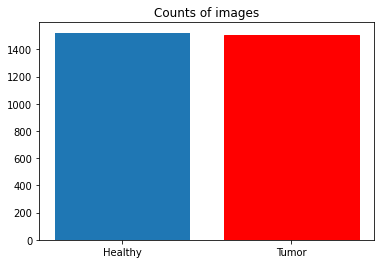

In [ ]:
c = Counter(lab)
p=plt.bar(('Healthy','Tumor'), c.values())
p[1].set_color('r')
plt.title('Counts of images');

In [ ]:
data=np.array(dataset).reshape(-1,64, 64, 3)
l=np.array(lab)

In [ ]:
print(data.shape, l.shape)

(3030, 64, 64, 3) (3030,)


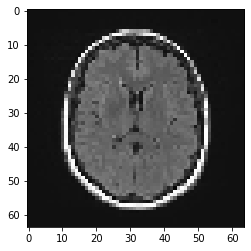

In [ ]:
plt.imshow(data[0])

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data,l,test_size=.25,random_state=7)


In [ ]:
adg_data=Sequential([
                     layers.RandomFlip('horizontal'),
                     layers.RandomRotation(.2),
                     layers.RandomZoom(.1)
])

In [ ]:
from keras.layers.convolutional import Conv
model=Sequential([
                  layers.Rescaling(1/255,input_shape=(64,64,3)),
                  adg_data,
                  layers.Conv2D(16,(3,3),activation='relu',padding='same'),
                  layers.MaxPooling2D((2,2)),Conv2D(64,(3,3),activation='relu',padding='same'),
                  layers.MaxPooling2D((2,2)),
                  layers.Conv2D(32,(3,3),activation='relu',padding='same'),
                  layers.MaxPooling2D((2,2)),
                  layers.Conv2D(64,(3,3),activation='relu',padding='same'),
                  layers.MaxPooling2D((2,2)),
                  layers.Dropout(.3),
                  layers.Flatten(),
                  layers.Dense(128,activation='relu'),
                  layers.Dense(64,activation='relu'),
                  layers.Dense(2,'softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
tb=TensorBoard()

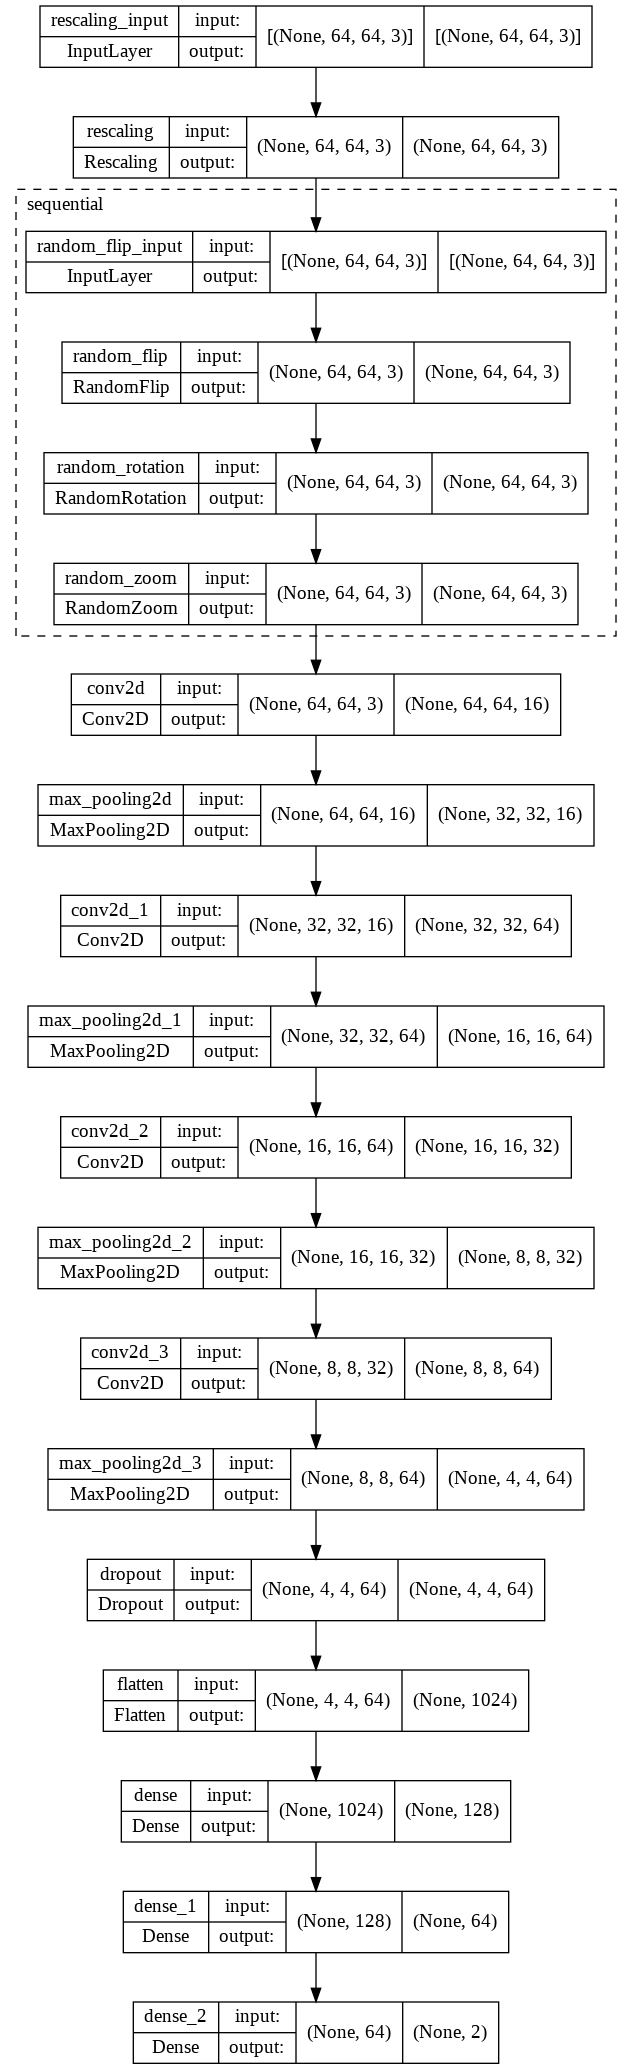

In [ ]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [ ]:
hist=model.fit(x_train,y_train,epochs=50,callbacks=tb,validation_data=(x_test,y_test))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


71/71 [==============================] - 4s 25ms/step - loss: 0.6074 - accuracy: 0.6765 - val_loss: 0.5388 - val_accuracy: 0.7427
Epoch 2/50
71/71 [==============================] - 1s 19ms/step - loss: 0.5432 - accuracy: 0.7262 - val_loss: 0.6203 - val_accuracy: 0.6913
Epoch 3/50
71/71 [==============================] - 1s 19ms/step - loss: 0.5155 - accuracy: 0.7421 - val_loss: 0.4620 - val_accuracy: 0.8127
Epoch 4/50
71/71 [==============================] - 1s 19ms/step - loss: 0.4845 - accuracy: 0.7790 - val_loss: 0.4568 - val_accuracy: 0.8021
Epoch 5/50
71/71 [==============================] - 1s 19ms/step - loss: 0.4700 - accuracy: 0.7892 - val_loss: 0.5697 - val_accuracy: 0.7678
Epoch 6/50
71/71 [==============================] - 1s 19ms/step - loss: 0.4613 - accuracy: 0.7892 - val_loss: 0.4672 - val_accuracy: 0.8179
Epoch 7/50
71/71 [==============================] - 1s 19ms/step - loss: 0.4600 - accuracy: 0.7839 - val_loss: 0.4251 - val_accuracy: 0.8179
Epoch 8/50
71/71 [======

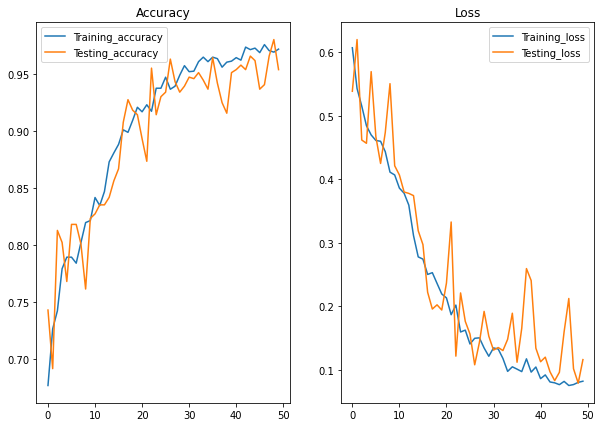

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(range(50),hist.history['accuracy'],label='Training_accuracy')
plt.plot(range(50),hist.history['val_accuracy'],label='Testing_accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(50),hist.history['loss'],label='Training_loss')
plt.plot(range(50),hist.history['val_loss'],label='Testing_loss')
plt.title('Loss')
plt.legend();

In [ ]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,1)
y_pred

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [ ]:
print(classification_report(y_test,y_pred,target_names=("Healthy","Brain Tumor" )))

              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.95       372
 Brain Tumor       0.95      0.96      0.95       386

    accuracy                           0.95       758
   macro avg       0.95      0.95      0.95       758
weighted avg       0.95      0.95      0.95       758



In [ ]:
mat=confusion_matrix(y_test,y_pred)
print(mat)

[[353  19]
 [ 16 370]]


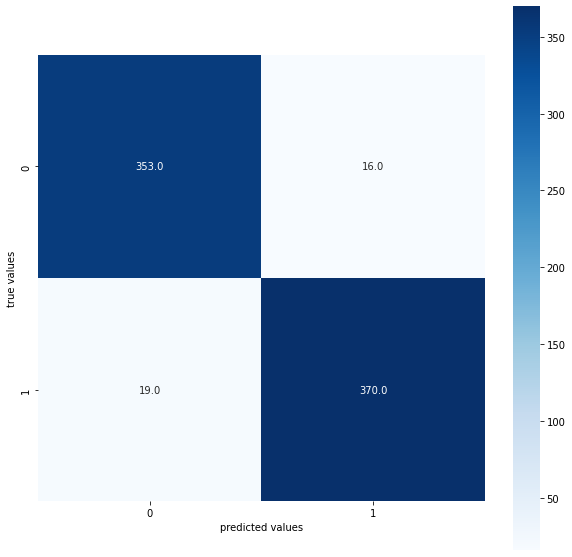

In [ ]:
import seaborn as sns
fig=plt.figure(figsize=(10,10))
sns.heatmap(mat.T,square=True,annot=True,cbar=True,cmap=plt.cm.Blues,fmt='.1f')
plt.xlabel('predicted values')
plt.ylabel('true values')
plt.show();